In [210]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [213]:
# read images
# image_names = glob("../data/splits/*.jpg")
# image_names = glob("../data/stitching/boat*.jpg")
# image_names = glob("../data/test1/DSC_*.jpg")
image_names = glob("../data/split_162930/*.jpg")
imgs = []
for i in image_names:
    _i = cv2.imread(i)
    _i = cv2.rotate(_i, cv2.ROTATE_90_CLOCKWISE)
    # _i = cv.resize(_i, (0,0), fx=0.25, fy=0.25)
    imgs.append(_i)
# return imgs, image_names

In [214]:
# get orb/brisk descriptor
img_ = imgs[1] # right
img = imgs[0] # left
# img_ = imgs[0] # left
# img = imgs[1] # right

In [215]:
img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [216]:
# Initiate SIFT detector
orb = cv2.ORB.create()

# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

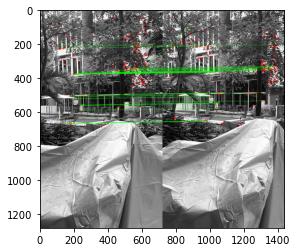

In [217]:
# flann matcher
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)  # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1.astype(np.float32),des2.astype(np.float32),k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,255,0), singlePointColor = (255,0,0), matchesMask = matchesMask, flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3)
plt.show()

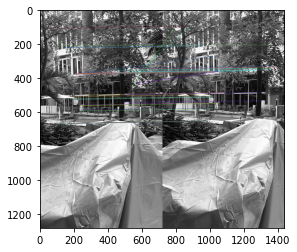

In [218]:
# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])
        
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

plt.imshow(img3)
plt.show()

In [219]:
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    # dst_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
    # srt_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
    src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    
    # h,w = img1.shape
    # pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    # dst = cv2.perspectiveTransform(pts, M)
    
    # img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

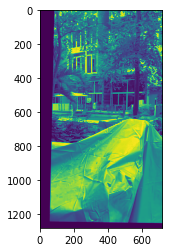

In [220]:
plt.imshow(cv2.warpPerspective(img1, M, (0,0)))

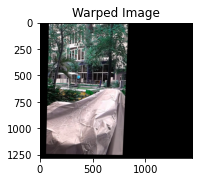

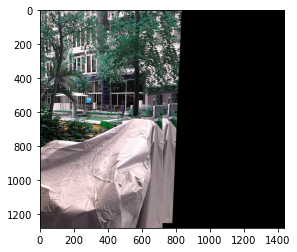

In [221]:
dst = cv2.warpPerspective(img, M, (img_.shape[1] + img.shape[1], img_.shape[0]))
plt.subplot(122),plt.imshow(dst),plt.title("Warped Image")
plt.show()
plt.figure()
dst[0:img.shape[0], 0:img.shape[1]] = img
# cv2.imwrite("output.jpg",dst)
plt.imshow(dst)
plt.show()

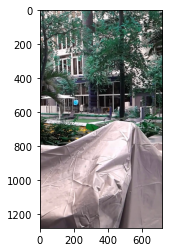

In [222]:
plt.imshow(img_)

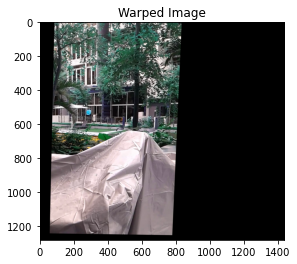

In [223]:
dst = cv2.warpPerspective(img_, M, (img.shape[1] + img_.shape[1], img.shape[0]))
plt.imshow(dst),plt.title("Warped Image")
plt.show()

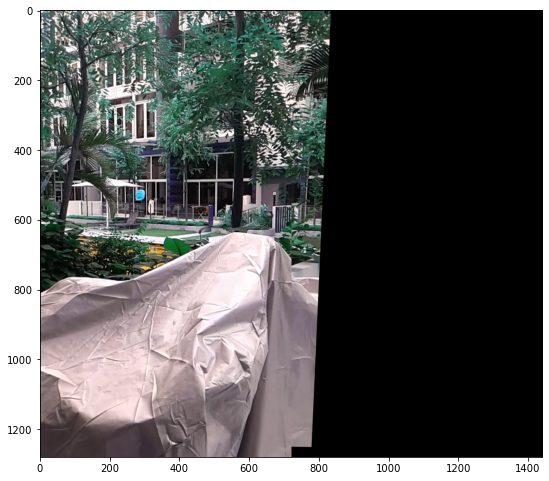

In [225]:
fig = plt.figure(figsize=(9,16))
dst[0:img.shape[0], 0:img.shape[1]] = img
# cv2.imwrite("output.jpg",dst)
plt.imshow(dst)
plt.show()

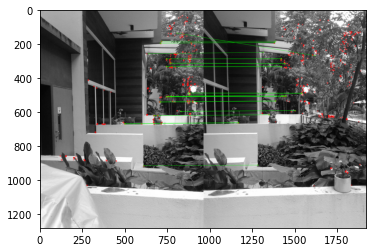

(<matplotlib.image.AxesImage at 0x1a0b050c9a0>, None)

In [171]:
# draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                    singlePointColor = None,
#                    matchesMask = matchesMask, # draw only inliers
#                    flags = 0)

img4 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img4), plt.show()